In [1]:
import os, warnings
#warnings.filterwarnings("ignore")
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import pandas as pd
#from statsmodels.tsa.stattools import adfuller, kpss, acf, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot
import numpy as np
from copy import deepcopy
import datetime
#pd.set_option('display.max_rows', 10**5)
pd.set_option('display.max_columns', 10**5)

from importlib import reload
import adtk
#import pweave     # for markdown reports

#os.chdir("..")
from claims_reporting.utils import tsa_utils as tsa
from claims_reporting.utils import utils_func as util
from claims_reporting.services import file

from claims_reporting.config import global_config as glob
#from claims_reporting.services import base
from claims_reporting.resources import config
from claims_reporting.resources import preprocessor_incurred as pre
from claims_reporting.resources import trainer

reload(tsa)
reload(file)
reload(config)
#reload(base)
reload(glob)
reload(trainer)
reload(pre)

#os.getcwd()
#reload(util)


/home/G126143/anaconda3/envs/env_finance/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/home/G126143/anaconda3/envs/env_finance/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<module 'claims_reporting.resources.preprocessor_incurred' from '/home/G126143/claims-anomaly-financial/src/claims_reporting/resources/preprocessor_incurred.py'>

In [2]:
periodicity = 12

if periodicity == 52:
    config_input = config.in_out52['input']
    config_output = config.in_out52['output']
    config_detect = config.in_out52['detection']
if periodicity == 12:    
    config_input = config.in_out12['input']
    config_output = config.in_out12['output']
    config_detect = config.in_out12['detection']

Read in source data:

In [3]:
filename = util.get_newest_file(search_for = "AGCS CCO CRA - Monthly Incurred amounts",  src_dir=glob.UC_DATA_DIR)
xls = file.XLSXService(path=filename, root_path=glob.UC_DATA_DIR, dtype= {'time': str}, sheetname='data', index_col=None, header=0)
print(filename)

data_orig = xls.doRead()

data_orig.shape

data_orig.rename(columns={'Line of Business': 'Lob', 'sum_incurred': 'target', 'Loss Category': 'Tier'}, inplace=True)

data_orig.head()

AGCS CCO CRA - Monthly Incurred amounts 08-11-2021.xlsx


,Lob,Region,OE,Year,time,Tier,target
0,ART,North America,Canada,2014,2014-04,Tier 0,0.0
1,ART,North America,Canada,2014,2014-11,Tier 0,0.0
2,ART,North America,Canada,2015,2015-04,Tier 0,0.0
3,ART,North America,US,2015,2015-04,Tier 0,0.0
4,ART,North America,Canada,2016,2016-01,Tier 0,0.0


In [4]:
#outlier_filter = config_detect['training']['outlier_filter']
hyper_para = config_detect['training']['hyper_para']
stat_transform = config_detect['training']['stat_transform']

# Instantiate class:
#--------------------
claims = pre.claims_reporting(ts_col = 'target')

outlier_filter = claims.outlier_filter
print(outlier_filter)

aggreg_level, pre_filter, ignore_lag, min_sample_size, min_median_target = list(config_detect['preprocessing'].values())

gen = claims.process_data(data_orig, aggreg_level = 'all_combi', ignore_lag = 1, min_sample_size = 30)

2021-05


### Iterate over sample and run outlier detection:

In [14]:
#df.target = df.target/10**6 
#df.head()

Claims from period 2014-01 to 2021-10.
Asia Pacific-Australia-Aviation-Tier 0 69
15 interpolated values due irregular time series


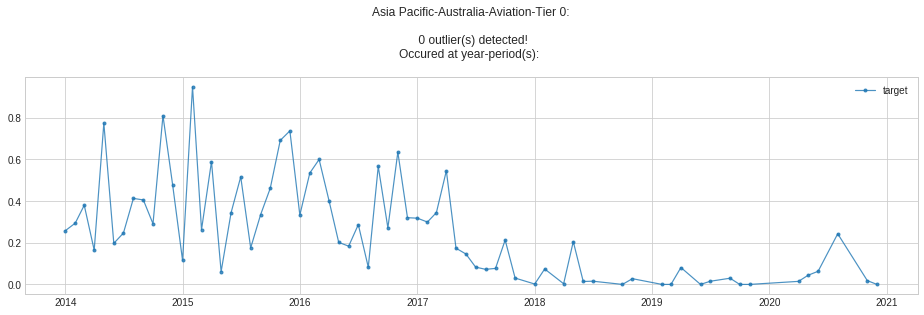

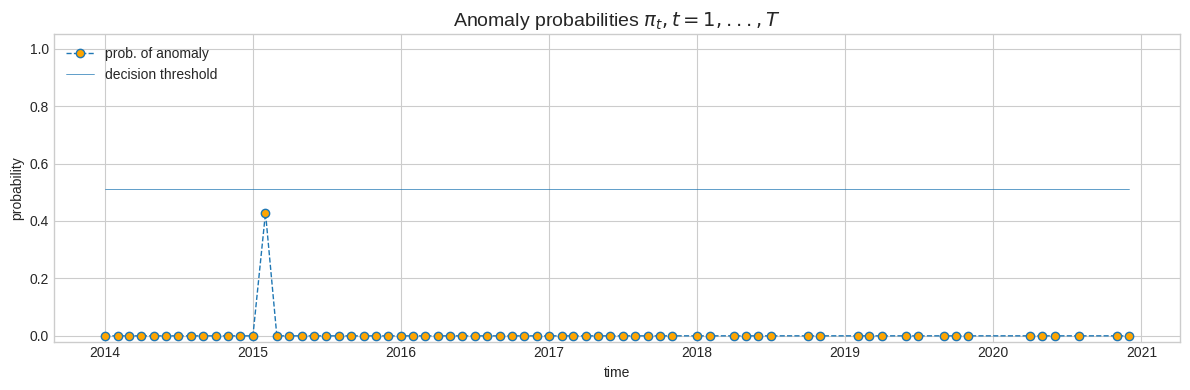

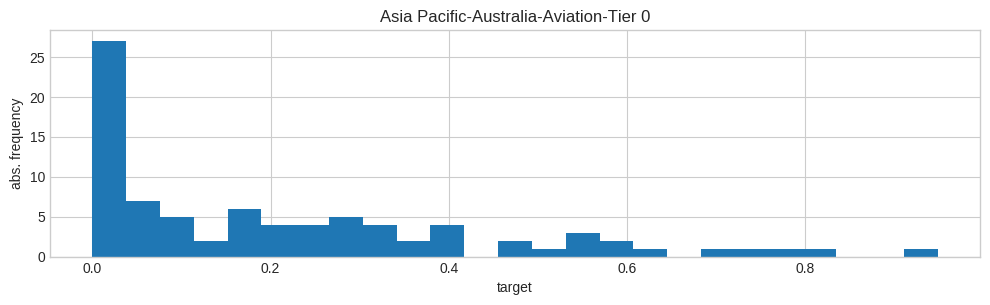

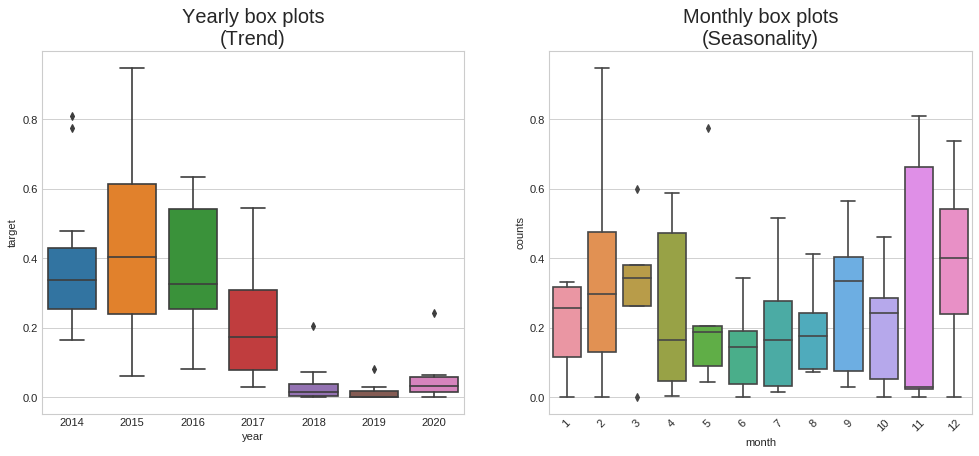

/home/G126143/anaconda3/envs/env_finance/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


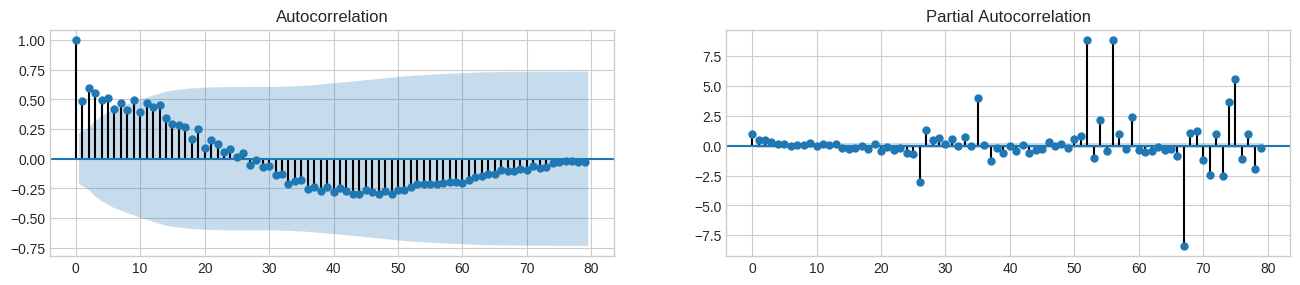

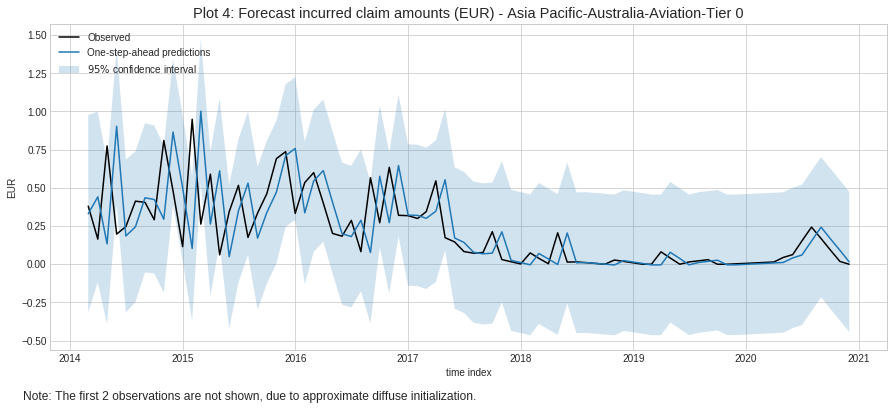

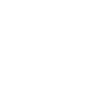

In [5]:
from adtk.visualization import plot
import statsmodels.api as sm
import matplotlib.ticker as ticker

# Get next series
#-------------------
label, sub_set = next(gen)

# Express in Million Euro:
sub_set.target = sub_set.target/10**6 

print('Claims from period {} to {}.'.format(claims.min_year_period, claims.max_year_period)) 

print(label, sub_set.shape[0])
df = deepcopy(sub_set)

train = trainer.trainer(periodicity = periodicity, verbose=False)
fitted = train.fit(df = df)

y = fitted.ts_values
old_n = len(y)

#y = y.asfreq(freq = 'MS', fill_value = 0.)     # use Month start
upsampled = y.resample('MS').mean()
y = upsampled.interpolate(method='linear')

new_n = len(y)
print('{} interpolated values due irregular time series'.format(new_n-old_n))
#y = fitted.val_series
out = fitted.predict(detect_thresh = None)

where = np.where(np.array(claims.time_index) == outlier_filter)[0][0]
outlier_search_list = claims.time_index[where:]

filtered_outliers = []
if out.nof_outliers > 0:
    outlier_dates = out.outlier_dates
    filt = [outl in outlier_search_list for outl in outlier_dates]
    filtered_outliers = np.array(outlier_dates)[filt].tolist()
    
    if len(filtered_outliers) > 0:
        #print("\nSeries",i)
        #print(label, sub_set.shape[0])
        print("Anomaly found!")
        print(filtered_outliers)
    
#lag = 1
#y_diff = util.difference(y, lag)
# First diff.
#util.ts_plot(x=x[lag:], y=y_diff, title='Weekly claim counts (First diff.): '+label) 

# Detect anomalies:
#----------------------
inside = ''    
if label in list(claims.level_wise_aggr.keys()):

    inside = claims.level_wise_aggr[label]       # then shows over which set it was aggregated    
    #new_inside = [str(i)+'\n' for i in inside] 
    
    #main = label +':\n\n '+ str(len(filtered_outliers)) + \
    #    ' outlier(s) detected!\n' + 'Occured at year-calendar week(s): '+ \
    #    ', '.join(filtered_outliers)+'\n'+'Aggregated over:'+str(new_inside)+'\n'
    
    main = label +':\n\n '+ str(len(filtered_outliers)) + \
            ' outlier(s) detected!\n' + 'Occured at year-period(s): '+ \
            ', '.join(filtered_outliers)+'\n'+'\nAggregated over: '
    for i in inside: main += str(i)+'\n'
    
else:
    main = label +':\n\n '+ str(len(filtered_outliers)) + \
        ' outlier(s) detected!\n' + 'Occured at year-period(s): '+ \
        ', '.join(filtered_outliers)+'\n'

    
pp = plot(fitted.val_series, anomaly_true = fitted.anomalies, ts_linewidth=1.2, ts_markersize=6, 
     at_markersize=5, at_color='red', freq_as_period=False, ts_alpha=0.8, at_alpha=0.5, title = main)


# other change point detection algos
#model = "rbf"  # "l2", "rbf"
#signal = train.s_deseasonal.to_numpy()
#signal = y.to_numpy()
#algo = rpt.Pelt(model=model, min_size=5).fit(signal)
#algo = rpt.Binseg(model=model).fit(signal)
#my_bkps = algo.predict(pen=np.log(len(signal))*np.std(signal)**2)

#ind = np.zeros(len(fitted.anomalies))
#ind[np.array(my_bkps)-1] = 1
#anomalies_algo = pd.Series(ind,name=fitted.anomalies.name, index=fitted.anomalies.index)
#bb = plot(fitted.val_series, anomaly_true = anomalies_algo, ts_linewidth=1.2, ts_markersize=6, 
#     at_markersize=5, at_color='red', freq_as_period=False, ts_alpha=0.8, at_alpha=0.5, title = "Algo")

#ticklabels = pp.get_xticks().tolist()
#pp.set_xticklabels(df['time'].tolist())
#pp.get_xticklabels()
#pp.get_xticks().tolist()
#pp.set_xticklabels(a)

# Anomaly probabilities:
#-------------------------
plt.figure(figsize=(12,4), dpi=100)
pro = plt.plot(fitted.anomaly_proba.index, fitted.anomaly_proba, color='tab:blue',label="prob. of anomaly", linestyle='--', marker='o', markerfacecolor='orange', linewidth=1)
plt.plot(fitted.anomaly_proba.index, [fitted.detect_thresh]*len(fitted.anomaly_proba.index), label="decision threshold",  linewidth=.5)
plt.gca().set(title="", xlabel="time", ylabel="probability", ylim = plt.ylim(-0.02, 1.05))   #plt.xlim(left=0)
locs, labels = plt.xticks()
#plt.xticks(y.index[0::3], labels=df['time'].to_numpy()[0::3], rotation=60)
plt.title(r'Anomaly probabilities $\pi_{t}, t=1,...,T$', fontdict = {'fontsize' : 14})
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()  

#start, end = pp.get_xlim()
#pp.xaxis.set_ticks(np.linspace(start, end, num=len(fitted.df['time'].values.tolist()[0::3])))
#pp.set_xticklabels(fitted.df['time'].values.tolist()[0::3], rotation=65)

#pp.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))

# Density plots
#----------------------------------------------------
plt.figure(figsize=(12,3), dpi=100)
#plt.subplot(211)
y.hist(bins=25)
plt.gca().set(title=label, xlabel="target", ylabel="abs. frequency")
#--------------------------------------------------------------------
#plt.subplot(212)
#log_y = np.log(1 + y)
#log_y.hist(bins=15)
#plt.gca().set(title='', xlabel="log counts", ylabel="abs. frequency")
#plt.subplot(212)
#y.plot(kind='kde')
#plt.gca().set(title='', xlabel="counts", ylabel="density")
#------------------------------------------------------------------------
# Draw Boxplot
if periodicity == 52 :
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,6), dpi= 80)
if periodicity == 12 :    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6), dpi= 80)
sns.boxplot(x='year', y='target', data=sub_set, ax=axes[0])
sns.boxplot(x='month', y='target', data=sub_set, ax=axes[1]).set(ylabel="counts")

if periodicity == 52 :
    sns.boxplot(x='period', y='target', data=sub_set, ax=axes[2], orient='v').set(
    xlabel='week', ylabel="counts")
#------------------------------------------------------------------------------------------

# Set Titles
axes[0].set_title('Yearly box plots\n(Trend)', fontsize=18) 
axes[1].set_title('Monthly box plots\n(Seasonality)', fontsize=18)
if periodicity == 52 :
    axes[2].set_title('Weekly box plots\n(Seasonality)', fontsize=18)
#plt.yticks(rotation=15)
plt.xticks(rotation=45)

plt.show()

# Bayesian:
#trim = 3
#probm = exact_post_cp(y.values[trim:], alpha = .2, beta = .2, gamma = .2, delta = .2)

#x = np.arange(0, len(y))
#fig, ax = plt.subplots()
#rects1 = ax.bar(x, np.append(np.zeros(3), probm), label='posterior', width = 4)
#plt.title('Posterior p.m.f. of change point')
#plt.show()
#plt.plot(x,y,'b')
#plt.axvline(x[np.argmax(probm)], color='k', linestyle='--', lw=.65)

# Calculate ACF and PACF upto 50 lags
# acf_50 = acf(df.value, nlags=50)
# pacf_50 = pacf(df.value, nlags=50)

# Calculate ACF and PACF 
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(y, lags=len(y)-5, ax=axes[0])
plot_pacf(y, lags=len(y)-5, ax=axes[1])


# SSM: Forecast future values:
#-------------------------------------------------------------    
#n_step_ahead = list(config_detect['prediction'].values())[0]
#endog = np.log(1 + y).to_numpy()
endog = deepcopy(y)
#endog.index = pd.DatetimeIndex(endog.index).to_period('M')   # set frequency explicitly (for stats model)
mod_uc = sm.tsa.UnobservedComponents(endog, 
                                     'random walk with drift'
                                     #cycle=False, 
                                     #seasonal=periodicity
                                     #level=True,
                                     #trend=False,
                                     #autoregressive = 1   # states
                                     #irregular=False,
                                     #stochastic_level=True
                                     #stochastic_cycle=False
                                     )

res_uc = mod_uc.fit(method='powell', disp=False)
#res_uc = mod_uc.fit(disp=False, cov_type = "robust_approx")

# Plot 4:
#----------
fig = res_uc.plot_components(level=False, trend=False, seasonal=False, cycle=False, autoregressive=False,
                             legend_loc='upper left', figsize=(15, 6))
axes = fig.get_axes()
axes[0].set_xlabel('time index')
axes[0].set_title("Plot 4: Forecast incurred claim amounts (EUR) - "+label, fontsize=14.5)
a = axes[0].set_ylabel('EUR')

# Logging
plt.figure(figsize=(1,1))
plt.text(0.05, 0.05, '', ha='center', va='center', size=.1, wrap=True)
plt.axis('off')
plt.show() 


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/structural.py:1661: RuntimeWarning: invalid value encountered in sqrt
  std_errors = np.sqrt(component_bunch['%s_cov' % which])


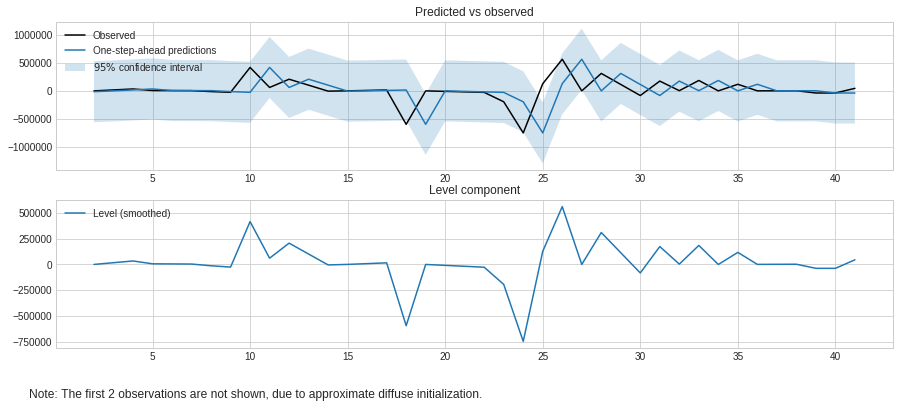

In [104]:
endog = deepcopy(y.tolist())
#endog.index = pd.DatetimeIndex(endog.index).to_period('M')   # set frequency explicitly (for stats model)
mod_uc = sm.tsa.UnobservedComponents(endog, 
                                     'random walk with drift' 
                                     #cycle=False, 
                                     #seasonal=periodicity
                                     #level=True,
                                     #trend=False,
                                     #autoregressive = 1   # states
                                     #irregular=False,
                                     #stochastic_level=True
                                     #stochastic_cycle=False
                                     )

res_uc = mod_uc.fit(method='powell', disp=False)
#res_uc = mod_uc.fit(disp=False, cov_type = "robust_approx")

# Plot 4:
#----------
fig = res_uc.plot_components(level=True, trend=False, seasonal=False, cycle=False, autoregressive=False,
                             legend_loc='upper left', figsize=(15, 6))

In [106]:
#print(res_uc.summary())

In [66]:
#https://www.statsmodels.org/stable/examples/notebooks/generated/statespace_local_linear_trend.html
predict = res_uc.get_prediction()
#forecast = res_uc.get_forecast('2014')

In [69]:
cond_mean_y = predict.predicted_mean #.plot(ax=ax, label='One-step-ahead Prediction')
predict_ci = predict.conf_int(alpha=0.05)
#predict_ci

In [70]:
endog = deepcopy(y)
#endog.index = pd.DatetimeIndex(endog.index).to_period('M') 
#endog

In [26]:
#?res_uc.plot_components

In [98]:
#?sm.tsa.UnobservedComponents

#fitted.anomaly_proba

In [125]:
#?res_uc.plot_components

In [118]:
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA, ARMA
#from statsmodels.tsa.vector_ar.var_model import VAR
#from statsmodels.tsa.statespace.varmax import VARMAX
#from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [119]:
ex = ExponentialSmoothing(y, trend = "add")

In [124]:
model_fit = model.fit()
yhat = model_fit.predict()

In [123]:
arma_mod = ARIMA(y, order=(2, 0, 0))
model_fit = arma_mod.fit()
yhat = model_fit.predict()

Test something

In [ ]:
# Get next series
#-------------------
label, sub_set = next(gen)

print(label, sub_set.shape[0])
df = deepcopy(sub_set)

train = trainer.trainer(verbose=False)
fitted = train.fit(df = df)

y = fitted.ts_values
out = fitted.predict(detect_thresh = None)

In [ ]:
from adtk.detector import OutlierDetector
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

outlier_detector = OutlierDetector(LocalOutlierFactor(contamination=0.01))
#outlier_detector = OutlierDetector(IsolationForest(n_estimators = 10))

anomalies = outlier_detector.fit_detect(y.to_frame())
anomalies

In [ ]:
#?OutlierDetector

BOCD:

In [ ]:
from claims_reporting.resources import bocd

reload(bocd)

T = len(y)
hazard = .01  # Constant prior on changepoint probability.
mean0  = 0      # The prior mean on the mean parameter.
var0   = 2      # The prior variance for mean parameter.
varx   = 1      # The known variance of the data.
cps = None

model = bocd.GaussianUnknownMean(mean0, var0, varx)
bc = bocd.BayesOCPD(model, hazard, mini_run_length = 2)

In [ ]:
from adtk.detector import AutoregressionAD

?AutoregressionAD

In [ ]:
cp_hat = bc.fit_predict(X = y.to_numpy())

R, pmean, pvar, cps_MAP, cps_est = bc.R, bc.pmean, bc.pvar, bc.cps_MAP, bc.cps_est

In [ ]:
bocd.plot_posterior(T, y.to_numpy(), cps, cps_est, R, pmean, pvar, True)

# Run all

In [13]:
from claims_reporting.utils import tsa_utils as tsa
from claims_reporting.utils import utils_func as util
from claims_reporting.services import file
from claims_reporting.config import global_config as glob
from claims_reporting.services import file
from claims_reporting.resources import config

from adtk.visualization import plot
import statsmodels.api as sm

reload(tsa)
reload(file)
reload(config)
reload(glob)
reload(util)

<module 'claims_reporting.utils.utils_func' from '/home/G126143/claims-anomaly-financial/src/claims_reporting/utils/utils_func.py'>

In [20]:
train = trainer.trainer(verbose=True)

results, results_new = train.run_all(data_orig = data_orig, aggreg_level = 'lob_only', write_table = False, verbose=True)

#results = deepcopy(results_new)

Detect anomalies not older than 2021-04.
Periodicity: 12
Aggregation type: 'lob_only'
Parameters: ignore_lag 1, min_sample_size 30, min_median_target None
pre-filter applied.
Ignoring claims after than: 2021-06
Number of left over aggregations ('Level 3'): 14
Using 7 base outlier detectors...

-> 1 outlier(s) detected!
Occured at year-period(s):
 [Timestamp('2018-05-01 00:00:00')]
Using 7 base outlier detectors...

-> 0 outlier(s) detected!
Occured at year-period(s):
 []
Using 7 base outlier detectors...

-> 0 outlier(s) detected!
Occured at year-period(s):
 []
Using 7 base outlier detectors...

-> 1 outlier(s) detected!
Occured at year-period(s):
 [Timestamp('2020-03-01 00:00:00')]
Using 7 base outlier detectors...

-> 1 outlier(s) detected!
Occured at year-period(s):
 [Timestamp('2020-02-01 00:00:00')]
Using 7 base outlier detectors...

-> 2 outlier(s) detected!
Occured at year-period(s):
 [Timestamp('2019-04-01 00:00:00'), Timestamp('2019-10-01 00:00:00')]
Using 7 base outlier detec

In [15]:
from tabulate import tabulate

print(tabulate(results_new, tablefmt="pipe", headers="keys", showindex=True))

#tt = train.filt_suspects_plot['Liability-4-Cat']
#tt['anom_evidence'].values * tt['anom_flag'].values   # minus ignore lag = 1

| time_anomaly   | time_series_name   | incurred_amnt   |
||


In [16]:
new_anomalies = list(set(results_new['time_series_name']))

In [17]:
train.print_anomalies(search_term = "Marine")

-> 0 hits found for 'Marine'.


In [18]:
#print('Number of anomalies in database: {}'.format(train.anomaly_history.shape[0]))

In [19]:
for label, val in train.filt_suspects_plot.items():
    
    if label in new_anomalies:

        fitted_val_series = val['val_series']
        y = fitted_val_series
        
        old_n = len(y)
        upsampled = y.resample('MS').mean()
        y = upsampled.interpolate(method='linear')
        new_n = len(y)
        print('{} interpolated values due to irregular time series'.format(new_n-old_n))
        
        fitted_anomalies = val['anom_flag']
        anomaly_proba = val['anom_evidence']
        filtered_outliers = train.filt_suspects_values[label]['anomaly_dates']
        sub_set = train.filt_suspects_plot[label]['df']

        # Express in Million Euro:
        #sub_set.target = sub_set.target/10**6 

        inside = ''    
        if label in train.level_wise_aggr:    
            inside = train.level_wise_aggr[label]       # then shows over which set it was aggregated    
            main = label +':\n\n '+ str(len(filtered_outliers)) + \
                    ' outlier(s) detected!\n' + 'Occured at year-calendar week(s): '+ \
                    ', '.join(filtered_outliers)+'\n'+'\nAggregated over: '
            for i in inside: main += str(i)+'\n'
        else:
            main = 'Plot 1: '+label +':\n\n '+ str(len(filtered_outliers)) + \
                ' outlier(s) detected!\n' + 'Occured at year-calendar week(s): '+ \
                ', '.join(filtered_outliers)+'\n'
            
        # Plot 1:
        #---------
        p1 = plot(fitted_val_series, anomaly_true = fitted_anomalies, ts_linewidth=1.2, ts_markersize=6, 
             at_markersize=5, at_color='red', freq_as_period=False, ts_alpha=0.8, at_alpha=0.5, 
             title = main)

        plt.figure(figsize=(1,1))
        plt.text(0.05, 0.05, '', ha='center', va='center', size=.1, wrap=True)
        plt.axis('off')
        plt.show() 
        
        # Anomaly probabilities:
        #-------------------------
        plt.figure(figsize=(12,4), dpi=100)
        pro = plt.plot(anomaly_proba.index, anomaly_proba, color='tab:blue',label="prob. of anomaly", linestyle='--', marker='o', markerfacecolor='orange', linewidth=1)
        plt.plot(anomaly_proba.index, [train.detect_thresh]*len(anomaly_proba.index), label="decision threshold",  linewidth=.5)
        plt.gca().set(title="", xlabel="time", ylabel="probability", ylim = plt.ylim(-0.02, 1.05))   #plt.xlim(left=0)
        locs, labels = plt.xticks()
        #plt.xticks(y.index[0::3], labels=df['time'].to_numpy()[0::3], rotation=60)
        plt.title(r'Anomaly probabilities $\pi_{t}, t=1,...,T$', fontdict = {'fontsize' : 14})
        plt.legend(loc='upper left')
        plt.tight_layout()
        plt.show()          
        
        # Density plots
        #----------------------------------------------------
        plt.figure(figsize=(12,3), dpi=100)
        #plt.subplot(211)
        y.hist(bins=25)
        plt.gca().set(title=label, xlabel="target", ylabel="abs. frequency")
        #--------------------------------------------------------------------
        
        # Plot 2 + 3:
        #--------------------------------------------------------------------------
        # Draw Boxplot
        fig, axes = plt.subplots(1, 2, figsize=(14.5,5.5), dpi= 80)
        sns.boxplot(x='year', y='target', data=sub_set, ax=axes[0])
        sns.boxplot(x='period', y='target', data=sub_set)

        axes[0].set_title('Plot 2: Year-wise Box plots (Trend)', fontsize=14.5) 
        axes[1].set_title('Plot 3: Week-wise Box plots (Seasonality)', fontsize=14.5)
        plt.xticks(rotation=65)
        fig.tight_layout()
        plt.show()

        
        # Forecast time series:
        #-------------------------------------------------------------    
        #n_step_ahead = list(config_detect['prediction'].values())[0]
        #endog = np.log(1 + y).to_numpy()
        endog = deepcopy(y)
        mod_uc = sm.tsa.UnobservedComponents(endog, 
                                             'random walk with drift', 
                                             #cycle=False, 
                                             seasonal=periodicity, 
                                             #irregular=False,
                                             #stochastic_level=True, 
                                             #stochastic_cycle=False, 
                                             damped_cycle=False)

        res_uc = mod_uc.fit(method='powell', disp=False)
        #res_uc = mod_uc.fit(disp=False, cov_type = "robust_approx")

        # Plot 4:
        #----------
        fig = res_uc.plot_components(level=False, trend=False, seasonal=False, cycle=False, 
                                     legend_loc='upper left', figsize=(15, 6))
        axes = fig.get_axes()
        axes[0].set_xlabel('time index')
        axes[0].set_title("Plot 4: Forecast number of claims - "+label, fontsize=14.5)
        a = axes[0].set_ylabel('claim counts')

        # Logging
        plt.figure(figsize=(1,1))
        plt.text(0.05, 0.05, '', ha='center', va='center', size=.1, wrap=True)
        plt.axis('off')
        plt.show() 
        

In [13]:
results_new.head(10)

,time_anomaly,time_series_name,incurred_amnt
0,2020-12,Asia Pacific-1-Attritional,-8.607031e+06
1,2020-04,MED-1-Attritional,-3.044667e+07
2,2020-05,North America-1-Attritional,3.617985e+07
3,2020-06,North America-3-Large,4.086452e+08
4,2020-06,RUL-3-Large,1.461238e+08


In [ ]:
from claims_reporting.config import global_config as glob

reload(glob)

In [ ]:
pg = file.PostgresService(verbose=True)

In [ ]:
pg.doWrite(results_new.head(10), "claims_reporting_anomalies_incurred")    # if_exists = "append"